In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [4]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [5]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

In [6]:
tracking_df['gpid'] = tracking_df.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [7]:
runners = tracking_df.loc[(tracking_df['position'].isin(['WR'])) & (~tracking_df['route'].isna())].copy()

In [8]:
# Convert nan forced floats to ints and NA
runners['nflId'] = runners['nflId'].astype('Int64')
runners['jerseyNumber'] = runners['jerseyNumber'].astype('Int64')

In [9]:
gpids = runners['gpid'].unique().tolist()

In [10]:
runners.head()

,time,s,a,dis,event,nflId,displayName,jerseyNumber,position,frameId,...,gameId,playId,playDirection,route,pos,teamType,o_vec,dir_vec,r_vec,gpid
1,2018-09-16 17:04:00.799000+00:00,0.0,0.0,0.0,None,2495448,Randall Cobb,18,WR,1,...,2018091602,51,left,OUT,"[33.98, 22.22]",offense,"[0.98608322, -0.16625246]","[0.99999263, -0.00383971]","[0.25441302, -0.96709566]",2018091602-51
3,2018-09-16 17:04:00.799000+00:00,0.0,0.0,0.0,None,2543495,Davante Adams,17,WR,1,...,2018091602,51,left,GO,"[33.62, 15.44]",offense,"[0.95857152, -0.28485196]","[0.57671752, -0.81694364]","[0.06322728, -0.99799915]",2018091602-51
4,2018-09-16 17:04:00.799000+00:00,0.0,0.0,0.0,None,2556460,Geronimo Allison,81,WR,1,...,2018091602,51,left,HITCH,"[33.36, 8.33]",offense,"[0.95481269, -0.29720823]","[-0.84217018, 0.53921182]","[0.02353168, -0.99972309]",2018091602-51
7,2018-09-16 17:04:00.900000+00:00,0.0,0.0,0.0,None,2495448,Randall Cobb,18,WR,2,...,2018091602,51,left,OUT,"[33.98, 22.22]",offense,"[0.98608322, -0.16625246]","[0.98287108, -0.18429445]","[0.25451338, -0.96706925]",2018091602-51
9,2018-09-16 17:04:00.900000+00:00,0.0,0.0,0.0,None,2543495,Davante Adams,17,WR,2,...,2018091602,51,left,GO,"[33.62, 15.43]",offense,"[0.95857152, -0.28485196]","[0.57600438, -0.81744661]","[0.06317842, -0.99800225]",2018091602-51


In [56]:
routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
index = 0
end_events = ['pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
                       'pass_outcome_incomplete', 'first_contact', 'tackle', 'man_in_motion', 'play_action', 'handoff',
                       'pass_tipped', 'pass_outcome_interception', 'pass_shovel', 'line_set', 'pass_outcome_touchdown',
                       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered', 'touchdown', 'shift',
                       'touchback', 'penalty_flag', 'penalty_accepted', 'field_goal_blocked']

# Generate vectors of positions
for gpid in gpids[:1000]:
    df = runners.loc[runners['gpid'] == gpid]
    players = df['nflId'].unique().tolist()
    for player in players:
        player_df = df.loc[(df['nflId'] == player)]
        if player > 0:
            start_frame = df.loc[(df['nflId'] == player) & (df['event'] == 'ball_snap')]['frameId'].min()
            end_frame = df.loc[(df['nflId'] == player) & (df['event'].isin(end_events))]['frameId'].min()
            if end_frame > start_frame:
                positions = []
                for frame in range(start_frame + 1, end_frame + 1):
                    # positions.append(player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist())
                    new_pos = player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist()
                    new_pos.append(player_df.loc[(player_df['frameId'] == frame)]['s'].values[0])
                    positions.append(new_pos)
                positions = np.array(positions)
                try:
                    routes_df.loc[index] = {
                        'gpid': str(),
                        'nflId': int(player),
                        'route': str(player_df.loc[(player_df['frameId'] == 1)]['route'].values[0]),
                        'pos': positions - positions[0]
                    }
                    index += 1
                except IndexError:
                    print(f'Data error for gpid {gpid}, player {player} (Start {start_frame} | End {end_frame})')

In [12]:
# Convert position sequences to 2d array with np.histogram2d

In [13]:
# Convert 2d array to 1d array

(-34.0, 34.0)

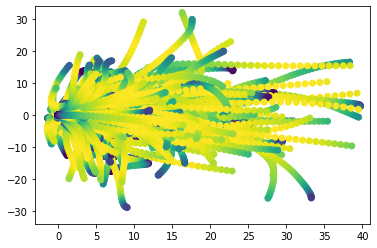

In [57]:
x = [0, 0]
y = [0, 0]

for idx, row in routes_df.iterrows():
    if row['pos'][:, 0].min() < x[0]: x[0] = row['pos'][:, 0].min()
    if row['pos'][:, 0].max() > x[1]: x[1] = row['pos'][:, 0].max()
    if row['pos'][:, 1].min() < y[0]: y[0] = row['pos'][:, 1].min()
    if row['pos'][:, 1].max() > y[1]: y[1] = row['pos'][:, 1].max()
    plt.scatter(row['pos'][:, 0], row['pos'][:, 1], c=row['pos'][:, 2])
x = [np.floor(x[0]), np.ceil(x[1])]
plt.xlim(x[0] - 1, x[1] + 1)
y[0] = -1 * np.ceil(max(abs(y[0]), abs(y[1])))
y[1] = abs(y[0])
plt.ylim(y[0] - 1, y[1] + 1)

In [74]:
for row in routes_df.iloc[0]['pos']:
    print(row[1])

0.0
0.00999999999999801
0.00999999999999801
0.030000000000001137
0.03999999999999915
0.05999999999999872
0.0799999999999983
0.08999999999999986
0.09999999999999787
0.09999999999999787
0.07000000000000028
0.00999999999999801
-0.08000000000000185
-0.21999999999999886
-0.40000000000000213
-0.620000000000001
-0.879999999999999
-1.1600000000000001
-1.490000000000002
-1.8099999999999987
-2.1400000000000006
-2.469999999999999
-2.8000000000000007
-3.1000000000000014
-3.3900000000000006


In [64]:
x_dim = int(abs(x[0]) + abs(x[1]))
y_dim = int(abs(y[0]) + abs(y[1]))

In [65]:
grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)

In [70]:
grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
grids = []
for idx, row in routes_df.iterrows():
    grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)
    for position in row['pos']:
        grid[int(position[0]), int(position[1])] = position[2]
    grids.append(grid.reshape(x_dim * y_dim))

In [102]:
# flatten the images
n_samples = len(routes_df.grid)
data = routes_df.grid.to_numpy().reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, routes_df['route'], test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

ValueError: setting an array element with a sequence.

array([[array([2.84, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([3.32, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([2.6, 0. , 0. , ..., 0. , 0. , 0. ])],
       [array([2.49, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([2.75, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([3.84, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([3.73, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([2.33, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([2.68, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([2.32, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([3.24, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([2.9, 0. , 0. , ..., 0. , 0. , 0. ])],
       [array([1.92, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([0.11, 0.26, 0.45, ..., 0.  , 0.  , 0.  ])],
       [array([1.71, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([0.58, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [array([1.81, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])],
       [a

In [112]:
n_grid.reshape((1, n_samples))

array([[array([2.84, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([3.32, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([2.6, 0. , 0. , ..., 0. , 0. , 0. ]),
        array([2.49, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([2.75, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([3.84, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([3.73, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([2.33, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([2.68, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([2.32, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([3.24, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([2.9, 0. , 0. , ..., 0. , 0. , 0. ]),
        array([1.92, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([0.11, 0.26, 0.45, ..., 0.  , 0.  , 0.  ]),
        array([1.71, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([0.58, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([1.81, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
        array([2.43, 0.  ,